In [2]:
%matplotlib notebook
from glob import glob
from astropy.time import Time
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii, fits
import seaborn as sns

In [3]:
from matplotlib.pyplot import cycler
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm

def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#plt.rcParams["axes.prop_cycle"] =
prop_cycle= get_cycle("tab20")
colors = prop_cycle.by_key()['color'] 

In [4]:
ztf_fp = pd.read_csv('data/J1957+032.txt', comment='#', index_col='index,', delim_whitespace=True)
ztf_fp.columns = [x.split(',')[0] for x in ztf_fp.columns]
ztf_fp.index.name = 'index'

In [5]:
ztf_fp.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

In [6]:
ztf_fp['mjd'] = Time(ztf_fp['jd'],format='jd').mjd
# ztf_fp['ra'] = 284.67325
# ztf_fp['dec'] = 22.65816667
# ztf_fp['bjd'] = apply_barycenter(ztf_fp)

In [20]:
ztf_fp.loc[32]

field                             1483
ccdid                               13
qid                                  2
filter                           ZTF_r
pid                      1998417145015
infobitssci                          0
sciinpseeing                    1.8844
scibckgnd                      242.012
scisigpix                      9.43395
zpmaginpsci                    26.2502
zpmaginpsciunc                0.000002
zpmaginpscirms                0.014188
clrcoeff                      0.076994
clrcoeffunc                   0.000007
ncalmatches                       1835
exptime                           30.0
adpctdif1                     0.064232
adpctdif2                     0.053677
diffmaglim                      20.299
zpdiff                         26.2502
programid                            2
jd                      2459752.917141
rfid                        1483120250
forcediffimflux             153.099002
forcediffimfluxunc           30.383639
forcediffimsnr           

In [8]:
# check for nonzero procstatus
wfp_bad = (ztf_fp.procstatus.apply(lambda x: str(x)) != '0')
np.sum(wfp_bad)
ztf_fp.loc[wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

,,,field,filter,ccdid,procstatus
field,filter,procstatus,,,,


In [10]:
ztf_fp.loc[~wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

ccdid
field filter procstatus       
490   ZTF_g  0              15
      ZTF_r  0              17
1483  ZTF_r  0               1

In [11]:
len(ztf_fp)

33

<IPython.core.display.Javascript object>


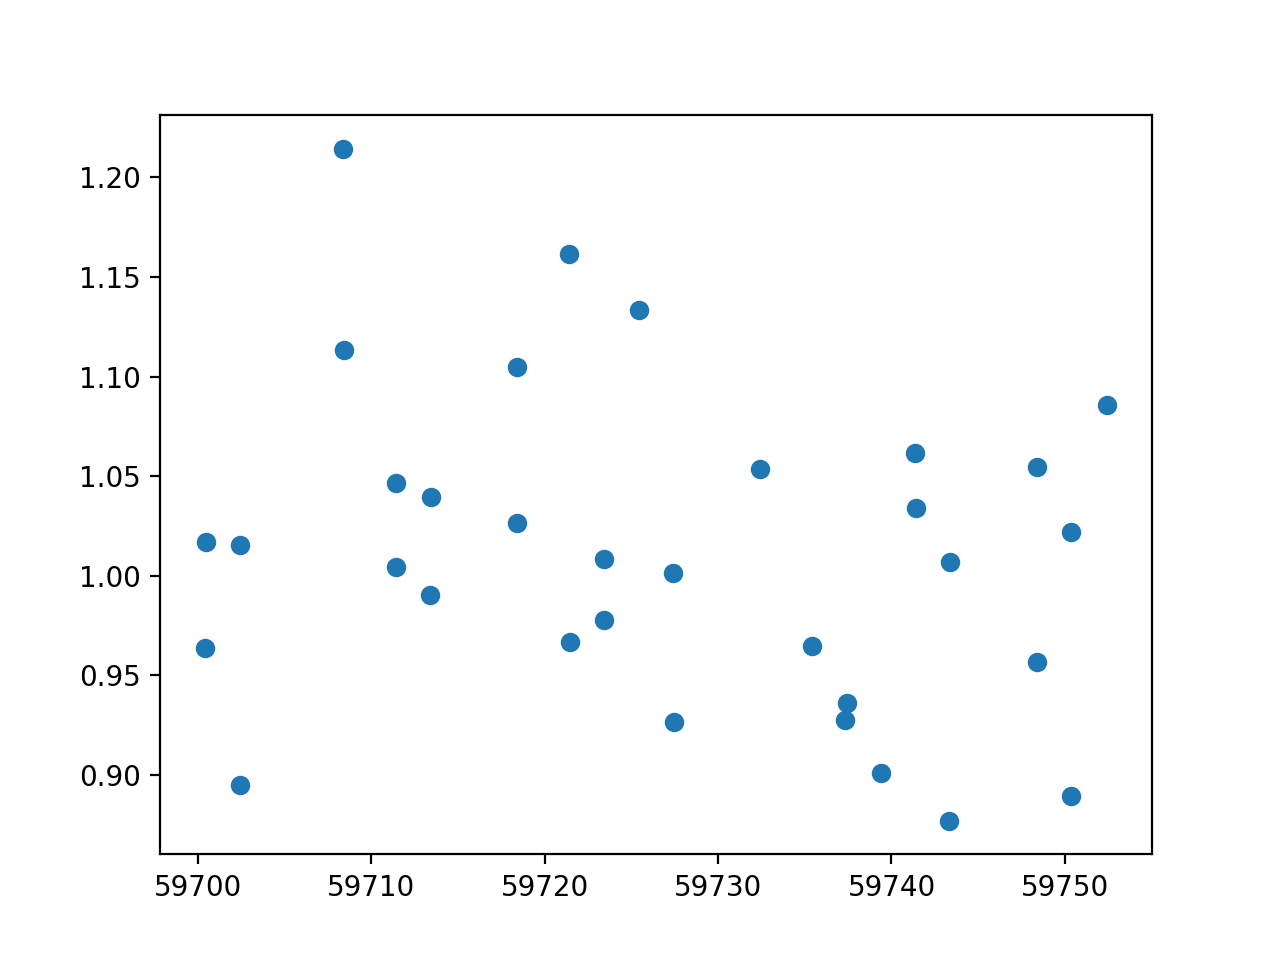

1.00830603561748


In [12]:
plt.figure()
plt.scatter(ztf_fp['mjd'],ztf_fp['forcediffimchisq'])
print(ztf_fp['forcediffimchisq'].median())

<IPython.core.display.Javascript object>


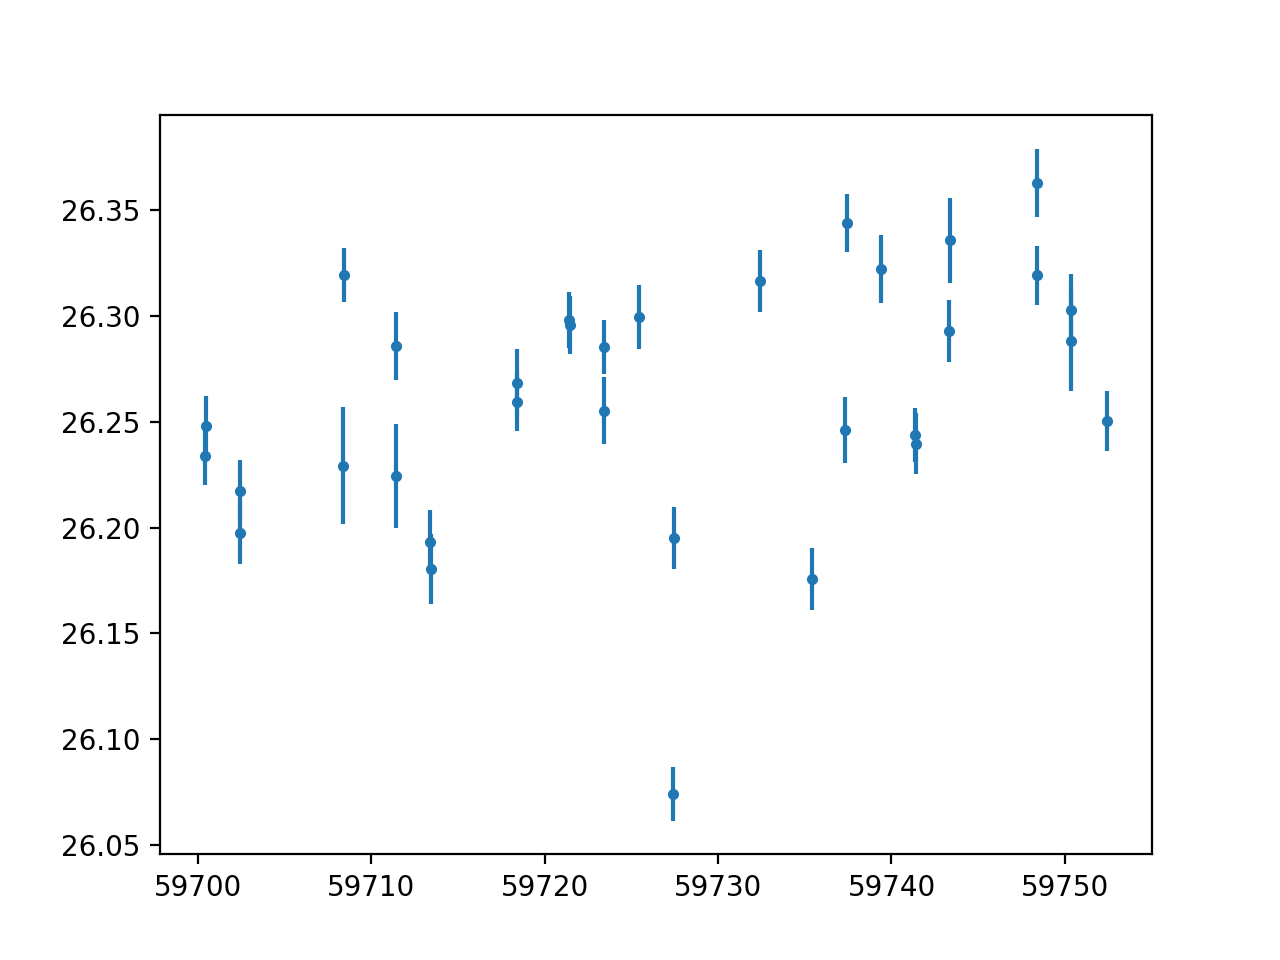

<ErrorbarContainer object of 3 artists>

In [13]:
plt.figure()
plt.errorbar(ztf_fp['mjd'],ztf_fp['zpmaginpsci'],ztf_fp['zpmaginpscirms'],fmt='.')

In [14]:
# TODO: need to check that nearest ref source is coincident and stellar
ztf_fp.loc[:,'nearestrefflux'] = 10**(0.4 * (ztf_fp['zpdiff'] - ztf_fp['nearestrefmag'])) 
ztf_fp.loc[:,'nearestreffluxunc'] = ztf_fp['nearestrefmagunc'] * ztf_fp['nearestrefflux']/ 1.0857
ztf_fp.loc[:,'dc_flux'] = ztf_fp['forcediffimflux'] + ztf_fp['nearestrefflux']
ztf_fp.loc[:,'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. - ztf_fp['nearestreffluxunc']**2.)
# fix any imaginary ones
ztf_fp.loc[ztf_fp.loc[:,'dc_flux_err'].isna(),'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. + ztf_fp['nearestreffluxunc']**2.)
ztf_fp.loc[:,'dc_snr'] = ztf_fp['dc_flux']/ztf_fp['dc_flux_err']
SNT = 3 # 3-sigma detection
SNU = 5 # 5-sigma upper limit

ztf_fp.loc[:,'dc_mag'] = np.NaN
ztf_fp.loc[:,'dc_mag_err'] = np.NaN
ztf_fp.loc[:,'dc_maglim'] = np.NaN

wzdet = ztf_fp['dc_snr'] > SNT
ztf_fp.loc[wzdet,'dc_mag'] = ztf_fp.loc[wzdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wzdet,'dc_flux'])
ztf_fp.loc[wzdet,'dc_mag_err'] = 1.0857 / ztf_fp['dc_snr']

ztf_fp.loc[~wzdet,'dc_maglim'] = ztf_fp.loc[~wzdet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[~wzdet,'dc_flux_err'])


# if we don't have reference sources the calculation is slightly different
wnoref = ztf_fp['nearestrefmag'].isna()
wnorefdet = wnoref & ((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)
wnorefnondet = wnoref & ~((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)

ztf_fp.loc[wnorefdet,'dc_mag'] = ztf_fp.loc[wnorefdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wnorefdet,'forcediffimflux'])
ztf_fp.loc[wnorefdet,'dc_mag_err'] = 1.0857 / (ztf_fp['forcediffimflux'] / ztf_fp.loc[wnorefdet,'forcediffimfluxunc'])
ztf_fp.loc[wnorefnondet,'dc_maglim'] = ztf_fp.loc[wnorefnondet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[wnorefnondet,'forcediffimfluxunc'])



In [15]:
ztf_fp

,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,...,procstatus,mjd,nearestrefflux,nearestreffluxunc,dc_flux,dc_flux_err,dc_snr,dc_mag,dc_mag_err,dc_maglim
index,,,,,,,,,,,,,,,,,,,,,
0,490,8,2,ZTF_r,1946434643015,0,2.5268,169.063,9.34481,26.2340,...,0,59700.434641,855.066566,20.476864,852.008833,33.701562,25.280989,18.907890,0.042945,NaN
1,490,8,2,ZTF_g,1946469763015,0,2.2820,107.924,6.56452,26.2480,...,0,59700.469768,524.807390,10.634395,523.945594,24.060553,21.776125,19.449785,0.049857,NaN
2,490,8,2,ZTF_r,1948430283015,0,2.8261,163.771,9.04780,26.1975,...,0,59702.430289,826.798967,19.799920,743.229104,33.254198,22.349933,19.019693,0.048577,NaN
3,490,8,2,ZTF_g,1948474673015,0,2.2484,104.330,5.63363,26.2173,...,0,59702.474676,510.175903,10.337911,482.905376,19.047825,25.352258,19.507645,0.042825,NaN
4,490,8,2,ZTF_r,1954364763015,8,4.9007,164.396,12.86520,26.2293,...,0,59708.364768,851.373102,20.388414,736.065483,63.912992,11.516680,19.062009,0.094272,NaN
5,490,8,2,ZTF_r,1954462113015,0,2.6590,180.021,9.00390,26.3193,...,0,59708.462118,924.953554,22.150495,841.904031,25.117627,33.518454,19.006144,0.032391,NaN
6,490,8,2,ZTF_g,1957436003015,0,2.7822,107.920,9.23170,26.2245,...,0,59711.436007,513.570349,10.406694,475.869634,42.686530,11.148005,19.530780,0.097390,NaN
7,490,8,2,ZTF_r,1957461873015,0,2.4278,177.136,9.14193,26.2858,...,0,59711.461875,896.850233,21.477486,853.382589,26.699850,31.962074,18.957941,0.033968,NaN
8,490,8,2,ZTF_r,1959402783015,0,1.8455,167.432,14.88150,26.1931,...,0,59713.402789,823.455103,19.719843,799.008113,44.836424,17.820514,18.936722,0.060924,NaN


In [16]:
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none')

NameError: name 'wg' is not defined

<IPython.core.display.Javascript object>


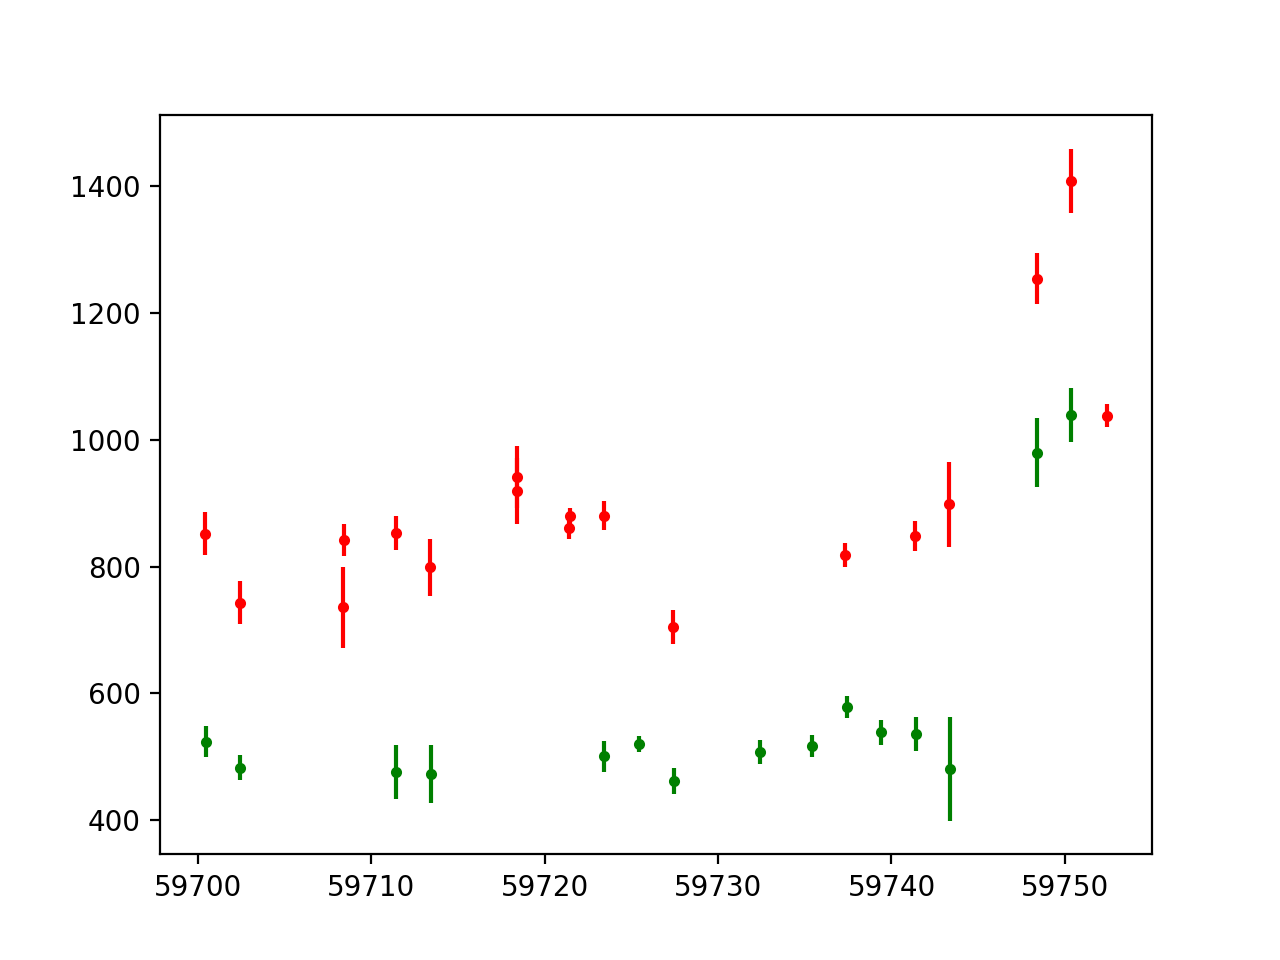

<ErrorbarContainer object of 3 artists>

In [17]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none', color='g')
plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_flux'],
             ztf_fp.loc[wr,'dc_flux_err'],fmt='.',ls='none', color='r')

In [57]:
colors = ['green', 'pink', 'red']

## Plot lc

In [22]:
# manual photometry
phot = pd.read_csv('phot_example/photdata.csv')

In [31]:
phot.sort_values('mjd').set_index('fid').sort_index()

,id,mjd,mag,magerr,pid
fid,,,,,
0.0,1.0,59747.452303,19.146907,0.103,2.0
0.0,1.0,59749.428276,19.164023,0.114,2.0
0.0,1.0,59750.431863,19.220642,0.095,2.0
1.0,1.0,59730.437500,18.901271,0.054,2.0
1.0,1.0,59732.456308,18.911378,0.063,2.0
1.0,1.0,59742.368843,18.812288,0.064,2.0
1.0,1.0,59751.389062,19.754595,0.145,2.0
1.0,1.0,59752.417141,18.945545,0.053,2.0


<IPython.core.display.Javascript object>


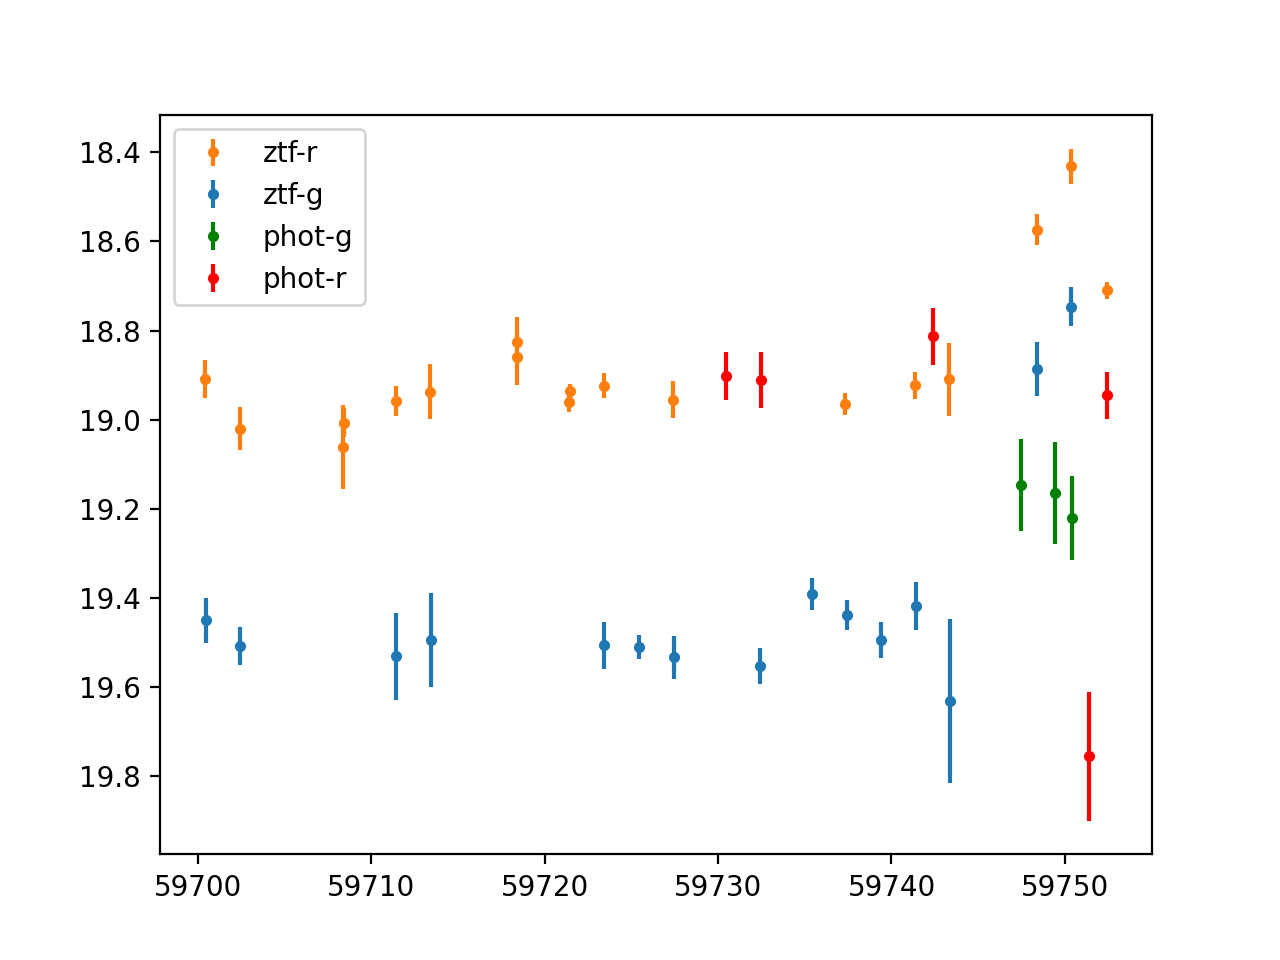

In [28]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
             ztf_fp.loc[wr,'dc_mag_err'],fmt='.',ls='none', color=colors[2], label='ztf-r')
plt.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[2])
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
             ztf_fp.loc[wg,'dc_mag_err'],fmt='.',ls='none', color=colors[0], label='ztf-g')
plt.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[0])

# plot manual photometry
FILTERS = {'g': 0, 'r': 1}
for filt in ['g', 'r']:
    w_phot = phot['fid'] == FILTERS[filt]
    plt.errorbar(phot.loc[w_phot, 'mjd'], phot.loc[w_phot, 'mag'], phot.loc[w_phot, 'magerr'], 
                 fmt='.', color=filt, label=f'phot-{filt}')

# plot cases without a reference
# plt.errorbar(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'dc_mag'],
#              ztf_fp.loc[wr&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[2])
# plt.scatter(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#             edgecolor='none',color=colors[2])
# plt.errorbar(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'dc_mag'],
#              ztf_fp.loc[wg&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[0])
# these no-ref limits seem to be spurious
#plt.scatter(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#            edgecolor='none',color=colors[0])

# TODO: consider marking bad points (procstatus !=0)
plt.legend()
plt.gca().invert_yaxis()

#### obs info

In [103]:
ztf_fp.query('59745 > mjd').groupby('filter')[['dc_mag', 'dc_mag_err']].count()

,dc_mag,dc_mag_err
filter,,
ZTF_g,13,13
ZTF_r,15,15


In [94]:
59748.367581 + 2400000.5

2459748.867581

In [95]:
ztf_fp[ztf_fp['mjd'] > 59749][['filter', 'mjd']]

,filter,mjd
index,,
30,ZTF_g,59750.330521
31,ZTF_r,59750.359942


In [16]:
pd.to_datetime(ztf_fp.set_index('filter').query('59743 < mjd')['mjd'] + 2400000.5, unit='D', origin='julian')

filter
ZTF_r   2022-06-13 07:37:25.996800
ZTF_g   2022-06-13 09:25:32.001600
ZTF_r   2022-06-18 08:49:18.998400
ZTF_g   2022-06-18 09:32:57.998400
ZTF_g   2022-06-20 07:55:56.997120
ZTF_r   2022-06-20 08:38:18.997440
ZTF_r   2022-06-22 10:00:40.999680
Name: mjd, dtype: datetime64[ns]

In [56]:
np.sum(ztf_fp.dc_snr > 3)

32

In [67]:
ztf_fp['dc_snr'].hist()

<AxesSubplot:>

In [17]:
ztf_fp.iloc[-1]

field                            1483
ccdid                              13
qid                                 2
filter                          ZTF_r
pid                     1998417145015
infobitssci                         0
sciinpseeing                   1.8844
scibckgnd                     242.012
scisigpix                     9.43395
zpmaginpsci                   26.2502
zpmaginpsciunc             2.3525e-06
zpmaginpscirms              0.0141879
clrcoeff                    0.0769942
clrcoeffunc               6.56088e-06
ncalmatches                      1835
exptime                            30
adpctdif1                    0.064232
adpctdif2                    0.053677
diffmaglim                     20.299
zpdiff                        26.2502
programid                           2
jd                        2.45975e+06
rfid                       1483120250
forcediffimflux               153.099
forcediffimfluxunc            30.3836
forcediffimsnr                5.60515
forcediffimc

In [ ]:
from astropy.io import fits